## Set up in Google Colab

In [ ]:
%%bash
apt-get update
apt-get install -y openjdk-8-jdk-headless -qq > /dev/null

wget -q "https://downloads.apache.org/spark/spark-3.1.1/spark-3.1.1-bin-hadoop2.7.tgz" > /dev/null
tar -xvf spark-3.1.1-bin-hadoop2.7.tgz > /dev/null

pip install pyspark findspark

In [2]:
# Set path to Spark
import os
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop2.7"

# Find Spark so that we can access session within our notebook
import findspark
findspark.init()

# Start SparkSession on all available cores
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

## Import packages and data

In [3]:
from pyspark.sql import SparkSession, Row, SQLContext
from pyspark.sql.functions import udf, col, date_format, to_date, trunc
import pyspark.sql.types as T
from pyspark.ml.feature import CountVectorizer, CountVectorizerModel, IDF, RegexTokenizer, StopWordsRemover
from pyspark.ml.clustering import LDA, LocalLDAModel
from pyspark.ml import Pipeline

import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

import numpy as np
import pandas as pd
import re
from math import ceil
from tqdm.notebook import tqdm

In [ ]:
from google.colab import files
uploaded = files.upload()

## Merging and basic cleaning

In [28]:
df = spark.read.csv("merged_df_final.csv", header=True)
df_governor = spark.read.csv("governor-twitter-handle.csv", header=True)

In [29]:
df = df[['province_state', 'date', 'confirmed_state', 'deaths_state', 'governor_tweet']]
df = df.drop_duplicates(subset=['governor_tweet', 'province_state'])
df = df.dropna()

In [30]:
df = df.join(df_governor, col('province_state') == col('State'), 'left')

## Exploratory Data Analysis

In [30]:
df.groupBy('Party').count().show()

+-----+-----+
|Party|count|
+-----+-----+
|  NPP|   64|
|    D| 6544|
|    R| 3704|
+-----+-----+



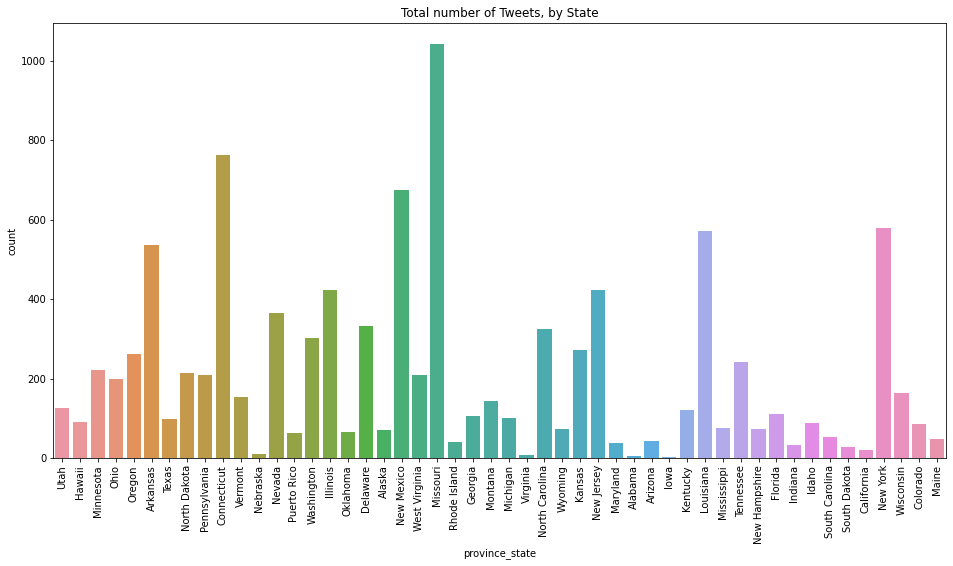

In [17]:
tweet_p_state = (df.groupBy('province_state')
                 .count())
tweet_p_state_df = tweet_p_state.toPandas()

plt.rcParams["figure.figsize"] = (16,8)
sns.barplot(x = 'province_state', y = 'count', data=tweet_p_state_df)
plt.title('Total number of Tweets, by State')
plt.xticks(rotation = 90, size = 10)
plt.show()

In [32]:
df = df.withColumn("date", to_date(col("date"), "yyyy/MM/dd"))
df = df.withColumn("year_month", trunc("date", "month"))

In [68]:
tweet_date_df = (df.groupBy('year_month')
                 .count()).toPandas().sort_values(by='year_month')
tweet_date_r_df = (df[df.Party == 'R'].groupBy('year_month')
                 .count()).toPandas().sort_values(by='year_month')
tweet_date_d_df = (df[df.Party == 'D'].groupBy('year_month')
                 .count()).toPandas().sort_values(by='year_month')                

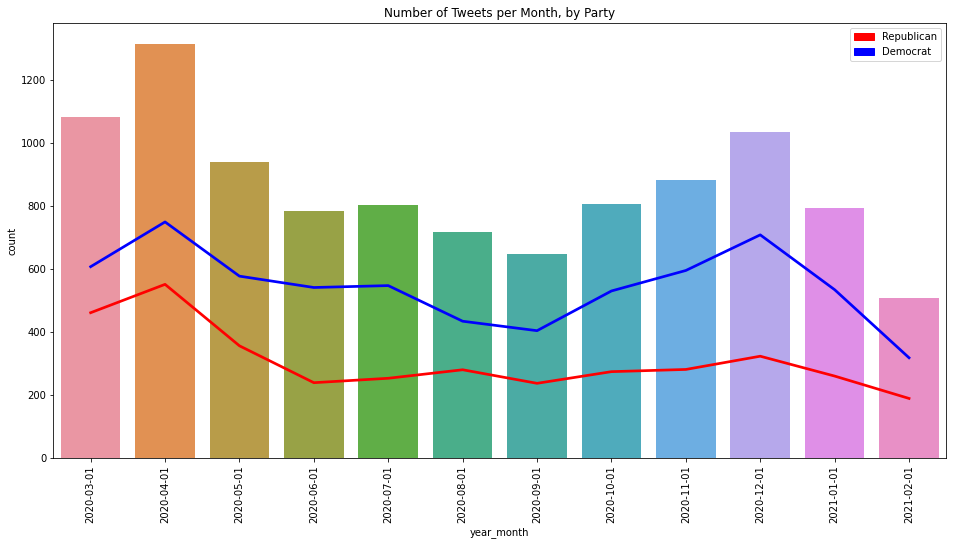

In [76]:
plt.clf()
plt.rcParams["figure.figsize"] = (16,8)

red_patch = mpatches.Patch(color='red', label='Republican')
blue_patch = mpatches.Patch(color='blue', label='Democrat')

sns.pointplot(x = 'year_month', y = 'count', color = 'red', data=tweet_date_r_df, label='Republican')
sns.pointplot(x = 'year_month', y = 'count', color = 'blue', data=tweet_date_d_df, label='Democrat')
sns.barplot(x = 'year_month', y = 'count', data=tweet_date_df, label='All')

plt.legend(handles=[red_patch, blue_patch])
plt.title('Number of Tweets per Month, by Party')
plt.xticks(rotation = 90, size = 10)

plt.show()

## Pre-processing

In [141]:
# Stop words
nltk.download('stopwords')
state_names = ["Alaska", "Alabama", "Arkansas", "American Samoa", "Arizona", "California", 
        "Colorado", "Connecticut", "District of Columbia", "Delaware", "Florida", 
        "Georgia", "Guam", "Hawaii", "Iowa", "Idaho", "Illinois", "Indiana", "Kansas", 
        "Kentucky", "Louisiana", "Massachusetts", "Maryland", "Maine", "Michigan", "Minnesota", 
        "Missouri", "Mississippi", "Montana", "North Carolina", "North Dakota", "Nebraska",
        "New Hampshire", "New Jersey", "New Mexico", "Nevada", "New York", "Ohio", "Oklahoma",
        "Oregon", "Pennsylvania", "Puerto Rico", "Rhode Island", "South Carolina", "South Dakota",
        "Tennessee", "Texas", "Utah", "Virginia", "Virgin Islands", "Vermont", "Washington",
        "Wisconsin", "West Virginia", "Wyoming"]
state_names = [state.lower() for state in state_names]
stop_words = set(stopwords.words("english") + state_names + ["which", "amp", "who", "whose", "xa", "de", "http", "https"])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# UDFs
removePunct = udf(
    lambda s: re.sub(r'[^a-zA-Z0-9]|[0-9]', r' ', s).strip().lower(), T.StringType())
removeStop = udf(
    lambda word: [x for x in word if (x not in stop_words) and (len(x) > 2)])
label_udf = udf(
    lambda x: x, T.ArrayType(T.StringType()))
ListOfIndexToWords = udf(
    lambda wl: list([vocabArray[w] for w in wl]))
FormatNumbers = udf(
    lambda nl: ["{:1.4f}".format(x) for x in nl])

In [ ]:
# Pipeline
cv = CountVectorizer(inputCol="final_words", outputCol="raw_features",vocabSize=20000, minDF=10.0)
idf = IDF(inputCol="raw_features", outputCol="features")
my_pipeline = Pipeline(stages=[cv,idf])

In [142]:
def preprocessing(df, party_specific = False):
    if party_specific is False:
    df = df
    else:
    df = df[df.Party == party_specific]

    texts=df.rdd.map(lambda x: x['governor_tweet'])
    tweets=texts.zipWithIndex()
    data = spark.createDataFrame(tweets, ["tweets",'index'])

    data_norm = data.withColumn("text", removePunct(data.tweets))
    df_tokens = tokenizer.transform(data_norm)
    df_tokens=df_tokens.withColumn('noStopWords',removeStop(df_tokens['words']))
    df_tokens=df_tokens.withColumn('final_words',label_udf(df_tokens.noStopWords))
    vocabArray = cv.fit(df_tokens).vocabulary
    result_tfidf = my_pipeline.fit(df_tokens).transform(df_tokens)
    return result_tfidf,vocabArray

## Model

In [168]:
def model_training(df, party_specific = False):
    if party_specific is False:
        result_tfidf = preprocessing(df)[0]
    else:
        result_tfidf = preprocessing(df, party_specific)[0]
        
    df_training, df_testing = result_tfidf.randomSplit([0.8, 0.2], seed=1)
    print('Training and testing documents: ', df_training.count(), df_testing.count())
    lda = LDA(k=10, maxIter=50, seed=10)
    return lda.fit(result_tfidf), df_training, df_testing

In [170]:
model_building_full = model_training(df)
model_building_r = model_training(df, 'R')
model_building_d = model_training(df, 'D')

Training and testing documents:  8214 2098
Training and testing documents:  2970 734
Training and testing documents:  5218 1326


## Result

In [171]:
def model_info(model, df, party_specific = False):
    topics = model[0].describeTopics(maxTermsPerTopic=5)
    vocabArray = preprocessing(df, party_specific)[1]
    numTopics=10

    toptopics = topics.select((topics.topic + 1).alias('topic'),
                            ListOfIndexToWords(topics.termIndices).alias('words'),
                            FormatNumbers(topics.termWeights).alias('weights'))
    toptopics.show(truncate=False, n=numTopics)
    print('Topics:', numTopics, 'Vocabulary:', len(vocabArray))

    lpt, lp = model[0].logPerplexity(model[2]), model[0].logPerplexity(model[1])
    print("Perplexity on testing and training data: " + str(lp) + ',' + str(lpt))

    llt, ll = model[0].logLikelihood(model[2]), model[0].logLikelihood(model[1])
    print("Likelihood on testing and training data: " + str(llt) + ',' + str(ll))

#### 1) Full Sample

In [174]:
model_info(model_building_full, df)

+-----+--------------------------------------------------+----------------------------------------+
|topic|words                                             |weights                                 |
+-----+--------------------------------------------------+----------------------------------------+
|1    |[communities, director, update, live, response]   |[0.0170, 0.0150, 0.0136, 0.0131, 0.0127]|
|2    |[statewide, deaths, data, hospitalized, currently]|[0.0278, 0.0254, 0.0250, 0.0241, 0.0219]|
|3    |[total, yesterday, hospitalizations, cases, new]  |[0.0473, 0.0373, 0.0297, 0.0271, 0.0243]|
|4    |[neighbors, child, may, care, find]               |[0.0087, 0.0086, 0.0083, 0.0081, 0.0068]|
|5    |[businesses, small, federal, relief, support]     |[0.0173, 0.0127, 0.0108, 0.0091, 0.0082]|
|6    |[students, school, contact, home, schools]        |[0.0094, 0.0086, 0.0076, 0.0073, 0.0070]|
|7    |[healthcare, days, lives, executive, protect]     |[0.0083, 0.0077, 0.0077, 0.0076, 0.0074]|


#### 2) Republican

In [172]:
model_info(model_building_r, df, 'R')

+-----+-----------------------------------------------+----------------------------------------+
|topic|words                                          |weights                                 |
+-----+-----------------------------------------------+----------------------------------------+
|1    |[stay, schools, cases, forward, risk]          |[0.0163, 0.0155, 0.0152, 0.0130, 0.0123]|
|2    |[announced, tested, well, wvgov, ever]         |[0.0152, 0.0137, 0.0108, 0.0107, 0.0096]|
|3    |[toll, essential, day, live, weve]             |[0.0209, 0.0155, 0.0150, 0.0145, 0.0138]|
|4    |[response, across, every, briefing, many]      |[0.0188, 0.0163, 0.0144, 0.0142, 0.0130]|
|5    |[get, fight, provide, spread, today]           |[0.0385, 0.0368, 0.0362, 0.0290, 0.0259]|
|6    |[watch, protect, know, wear, cases]            |[0.0285, 0.0180, 0.0158, 0.0150, 0.0140]|
|7    |[thank, also, business, state, phase]          |[0.0234, 0.0203, 0.0172, 0.0130, 0.0128]|
|8    |[update, reported, days

#### 3) Democrat

In [173]:
model_info(model_building_d, df, 'D')

+-----+-----------------------------------------------------+----------------------------------------+
|topic|words                                                |weights                                 |
+-----+-----------------------------------------------------+----------------------------------------+
|1    |[live, help, safe, visit, spread]                    |[0.0548, 0.0466, 0.0301, 0.0279, 0.0277]|
|2    |[make, increase, find, facilities, phase]            |[0.0142, 0.0123, 0.0120, 0.0100, 0.0092]|
|3    |[health, wearing, administered, information, economy]|[0.0137, 0.0129, 0.0103, 0.0088, 0.0087]|
|4    |[public, latest, cases, data, today]                 |[0.0174, 0.0170, 0.0165, 0.0148, 0.0147]|
|5    |[back, hard, face, great, business]                  |[0.0159, 0.0153, 0.0150, 0.0147, 0.0135]|
|6    |[todays, must, update, fight, watch]                 |[0.0444, 0.0333, 0.0329, 0.0291, 0.0284]|
|7    |[every, first, related, mexico, test]                |[0.0205, 0.0

## Visualization

In [175]:
def plot_wordclouds(topics, group, colormap="gist_heat"):
    cloud = WordCloud(
        background_color='white',
        width=800,
        height=600,
        colormap=colormap,
        prefer_horizontal=1.0,
    )

    num_topics = len(topics)
    fig = plt.figure(figsize=(25, 15))

    for idx, word_weights in tqdm(enumerate(topics), total=num_topics):
        ax = fig.add_subplot((num_topics / 5) + 1, 5, idx + 1)
        wordcloud = cloud.generate_from_frequencies(word_weights)
        ax.imshow(wordcloud, interpolation="bilinear")
        ax.set_title('Topic {}'.format(idx + 1), size = 16)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.tick_params(length=0)

    plt.tick_params(labelsize=16)
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    st = fig.suptitle('Topics of the {} Sample'.format(group), y=0.92, size = 16)
    fig.savefig("pyspark-topics.png", bbox_extra_artists=[st], bbox_inches='tight')

In [176]:
#Add more words to plot the wordcloud
def add_words(model):
    topics1 = model.describeTopics(maxTermsPerTopic=15)
    topics_rdd = topics1.rdd

    topic_words = topics_rdd \
          .map(lambda row: row['termIndices']) \
          .map(lambda idx_list: [vocabArray[idx] for idx in idx_list]) \
          .collect()
    topic_weights = topics_rdd \
          .map(lambda row: row['termWeights']) \
          .collect()
    topics1 = [dict(zip(words, weights)) for words, weights in zip(topic_words, topic_weights)]
    return topics1

#### 1) Full sample

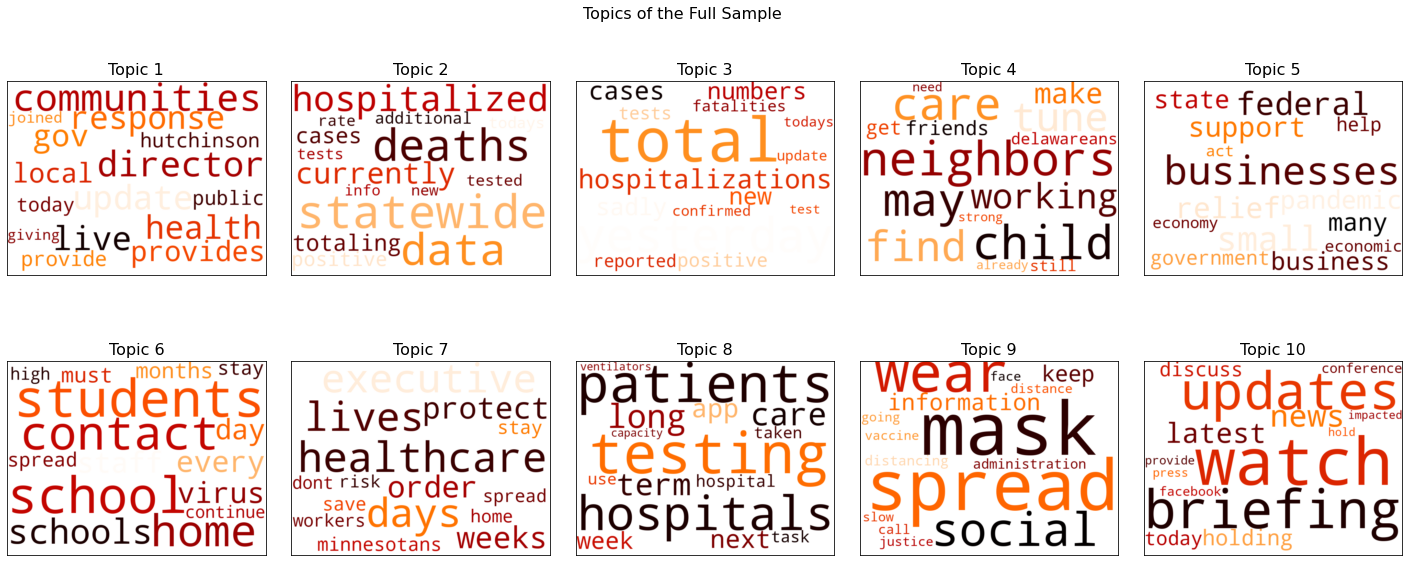

In [177]:
plot_wordclouds(add_words(model_building_full[0]),'Full')

#### 2) Republican

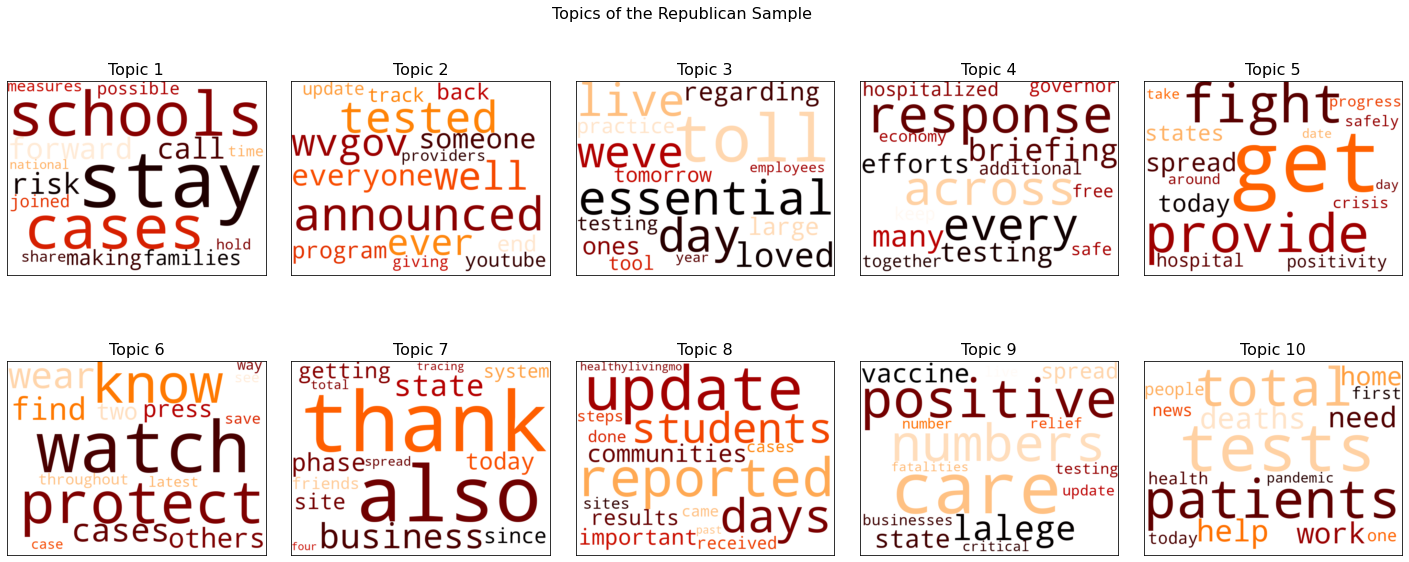

In [178]:
plot_wordclouds(add_words(model_building_r[0]),'Republican')

#### 3) Democrat

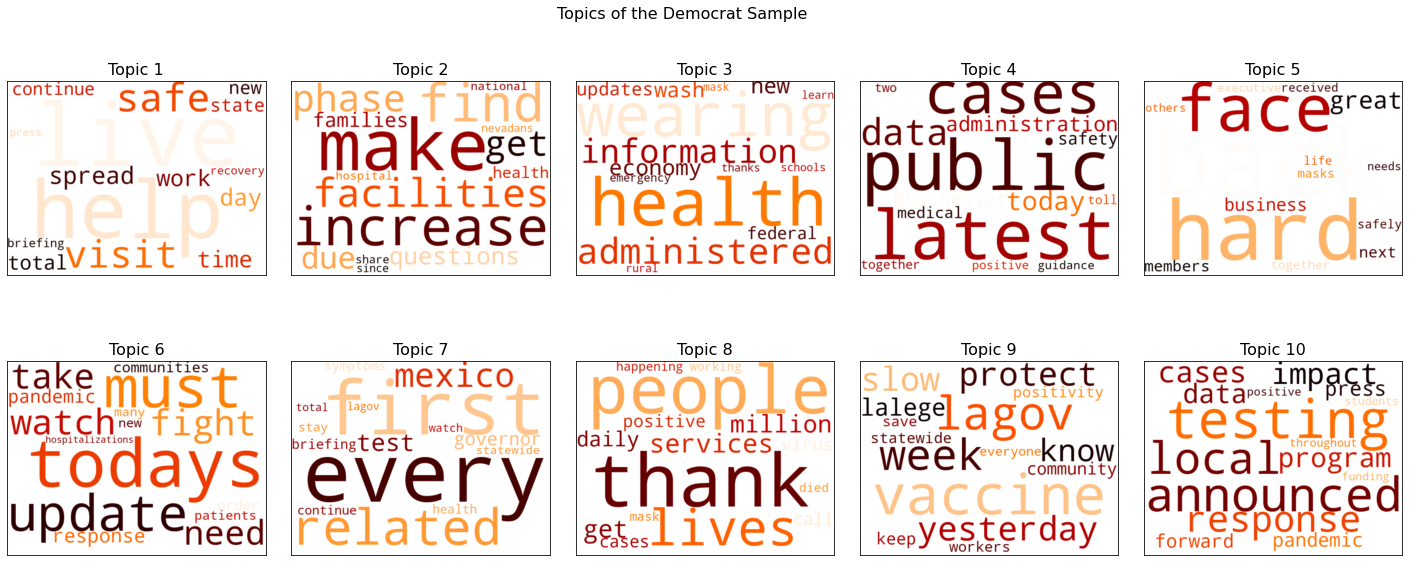

In [179]:
plot_wordclouds(add_words(model_building_d[0]),'Democrat')